In [54]:
import os
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd
from scipy.spatial.distance import squareform
import numpy as np
from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix
from Bio.Phylo.Consensus import majority_consensus
from matplotlib.gridspec import GridSpec
from math import ceil
from sklearn.metrics import silhouette_score

## Data preprocessing

In [55]:
file_path = 'data/db/output_results.txt' 
columns = ["Query ID", "Subject ID", "Percent Identity", "Alignment Length", "Mismatches", "Gap Opens", "Query Start", "Query End", "Subject Start", "Subject End", "E-value", "Bit Score"]

In [56]:
blast_df = pd.read_csv(file_path, sep="\t", names=columns)
print(blast_df.head())

                      Query ID                        Subject ID  \
0  albumin_Chlorocebus_sabaeus       albumin_Chlorocebus_sabaeus   
1  albumin_Chlorocebus_sabaeus       albumin_Macaca_fascicularis   
2  albumin_Chlorocebus_sabaeus            albumin_Macaca_mulatta   
3  albumin_Chlorocebus_sabaeus              albumin_Papio_anubis   
4  albumin_Chlorocebus_sabaeus  albumin_Trachypithecus_francoisi   

   Percent Identity  Alignment Length  Mismatches  Gap Opens  Query Start  \
0           100.000               608           0          0            1   
1            99.013               608           6          0            1   
2            98.849               608           7          0            1   
3            98.520               608           9          0            1   
4            95.888               608          25          0            1   

   Query End  Subject Start  Subject End  E-value  Bit Score  
0        608              1          608      0.0     1236.0  
1 

In [57]:
sequence_ids = blast_df['Query ID'].unique()
similarity_matrix = pd.DataFrame(np.zeros((len(sequence_ids), len(sequence_ids))), index=sequence_ids, columns=sequence_ids, dtype=float)

In [58]:
for _, row in blast_df.iterrows():
    query = row["Query ID"]
    subject = row["Subject ID"]
    identity = row["Percent Identity"]
    similarity_matrix.loc[query, subject] = identity

In [59]:
similarity_matrix

,albumin_Chlorocebus_sabaeus,albumin_Macaca_fascicularis,albumin_Macaca_mulatta,albumin_Papio_anubis,albumin_Rhinopithecus_roxellana,albumin_Trachypithecus_francoisi,albumin_Homo_sapiens,amylase_Chlorocebus_sabaeus,amylase_Macaca_fascicularis,amylase_Macaca_mulatta,...,prothrombin_Rhinopithecus_roxellana,prothrombin_Trachypithecus_francoisi,prothrombin_Homo_sapiens,thyroxine_Chlorocebus_sabaeus,thyroxine_Macaca_fascicularis,thyroxine_Macaca_mulatta,thyroxine_Papio_anubis,thyroxine_Rhinopithecus_roxellana,thyroxine_Trachypithecus_francoisi,thyroxine_Homo_sapiens
albumin_Chlorocebus_sabaeus,100.000,99.013,98.849,98.520,95.559,95.888,92.928,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
albumin_Macaca_fascicularis,99.013,100.000,99.836,99.507,95.888,96.217,93.421,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
albumin_Macaca_mulatta,98.849,99.836,100.000,99.342,96.053,96.382,93.586,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
albumin_Papio_anubis,98.520,99.507,99.342,100.000,95.559,95.888,93.092,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
albumin_Rhinopithecus_roxellana,95.559,95.888,96.053,95.559,100.000,99.013,92.763,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
albumin_Trachypithecus_francoisi,95.888,96.217,96.382,95.888,99.013,100.000,92.763,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
albumin_Homo_sapiens,92.928,93.421,93.586,93.092,92.763,92.763,100.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
amylase_Chlorocebus_sabaeus,0.000,0.000,0.000,0.000,0.000,0.000,0.000,100.000,98.434,98.434,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
amylase_Macaca_fascicularis,0.000,0.000,0.000,0.000,0.000,0.000,0.000,98.434,100.000,99.609,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
amylase_Macaca_mulatta,0.000,0.000,0.000,0.000,0.000,0.000,0.000,98.434,99.609,100.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## 1. Clustering

In [60]:
distance_matrix = 1 - (similarity_matrix / 100)

In [61]:
distance_matrix

,albumin_Chlorocebus_sabaeus,albumin_Macaca_fascicularis,albumin_Macaca_mulatta,albumin_Papio_anubis,albumin_Rhinopithecus_roxellana,albumin_Trachypithecus_francoisi,albumin_Homo_sapiens,amylase_Chlorocebus_sabaeus,amylase_Macaca_fascicularis,amylase_Macaca_mulatta,...,prothrombin_Rhinopithecus_roxellana,prothrombin_Trachypithecus_francoisi,prothrombin_Homo_sapiens,thyroxine_Chlorocebus_sabaeus,thyroxine_Macaca_fascicularis,thyroxine_Macaca_mulatta,thyroxine_Papio_anubis,thyroxine_Rhinopithecus_roxellana,thyroxine_Trachypithecus_francoisi,thyroxine_Homo_sapiens
albumin_Chlorocebus_sabaeus,0.00000,0.00987,0.01151,0.01480,0.04441,0.04112,0.07072,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
albumin_Macaca_fascicularis,0.00987,0.00000,0.00164,0.00493,0.04112,0.03783,0.06579,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
albumin_Macaca_mulatta,0.01151,0.00164,0.00000,0.00658,0.03947,0.03618,0.06414,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
albumin_Papio_anubis,0.01480,0.00493,0.00658,0.00000,0.04441,0.04112,0.06908,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
albumin_Rhinopithecus_roxellana,0.04441,0.04112,0.03947,0.04441,0.00000,0.00987,0.07237,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
albumin_Trachypithecus_francoisi,0.04112,0.03783,0.03618,0.04112,0.00987,0.00000,0.07237,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
albumin_Homo_sapiens,0.07072,0.06579,0.06414,0.06908,0.07237,0.07237,0.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
amylase_Chlorocebus_sabaeus,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.01566,0.01566,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
amylase_Macaca_fascicularis,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.01566,0.00000,0.00391,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000
amylase_Macaca_mulatta,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,0.01566,0.00391,0.00000,...,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


### Hierarchical clustering

In [62]:
linkage_matrix = linkage(distance_matrix, method='average')

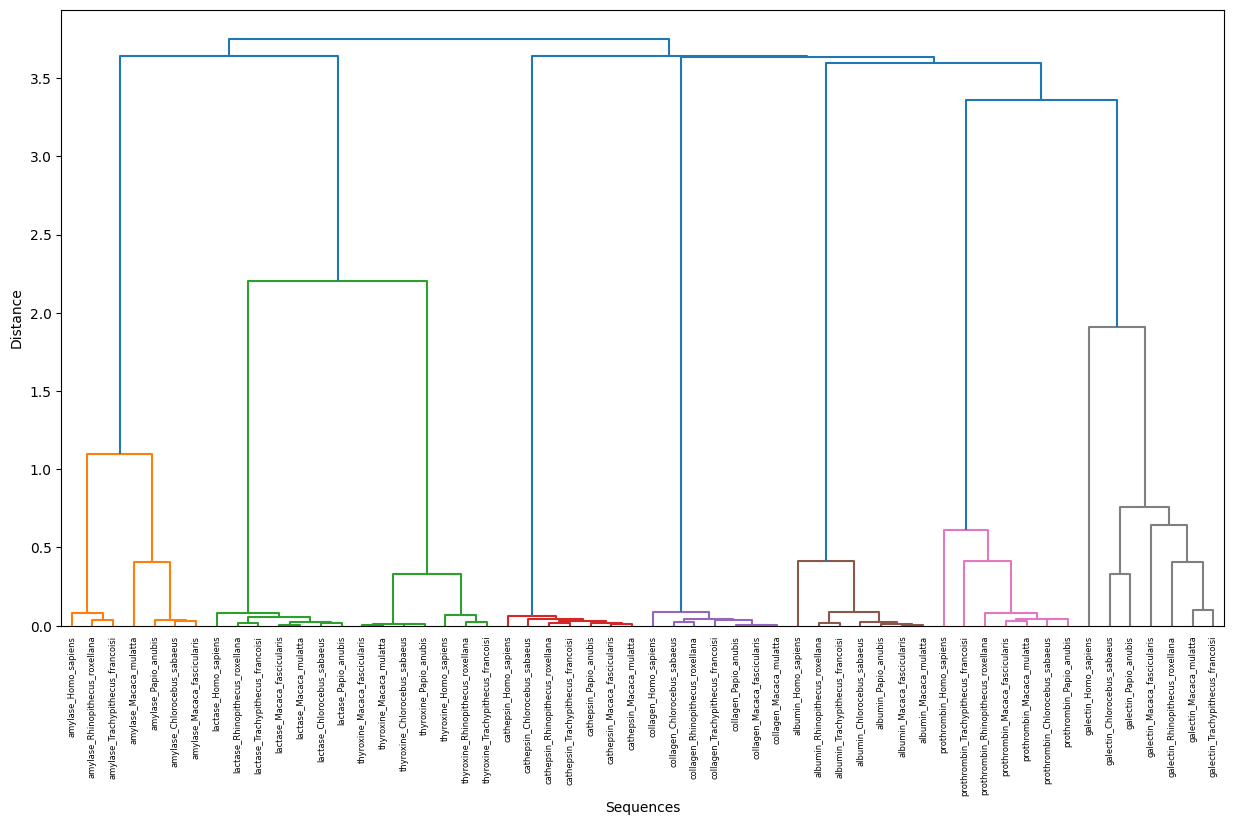

In [63]:
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=distance_matrix.index, leaf_rotation=90)
plt.xlabel("Sequences")
plt.ylabel("Distance")
plt.show()

### KMeans clustering

In [74]:
kmeans = KMeans(n_clusters=8)
clusters = kmeans.fit_predict(distance_matrix)
cluster_df = pd.DataFrame({'Sequence': distance_matrix.index, 'Cluster': clusters}).sort_values(by='Cluster')

In [75]:
for cluster in cluster_df['Cluster'].unique():
    print(f"Cluster {cluster + 1}:")
    print(cluster_df[cluster_df['Cluster'] == cluster]['Sequence'].to_list())
    print()

Cluster 1:
['galectin_Macaca_fascicularis', 'galectin_Chlorocebus_sabaeus', 'galectin_Macaca_mulatta', 'galectin_Papio_anubis', 'galectin_Rhinopithecus_roxellana', 'galectin_Homo_sapiens', 'galectin_Trachypithecus_francoisi']

Cluster 2:
['thyroxine_Trachypithecus_francoisi', 'thyroxine_Homo_sapiens', 'thyroxine_Macaca_fascicularis', 'thyroxine_Macaca_mulatta', 'thyroxine_Papio_anubis', 'thyroxine_Rhinopithecus_roxellana', 'thyroxine_Chlorocebus_sabaeus']

Cluster 3:
['cathepsin_Chlorocebus_sabaeus', 'cathepsin_Macaca_fascicularis', 'cathepsin_Macaca_mulatta', 'cathepsin_Papio_anubis', 'cathepsin_Rhinopithecus_roxellana', 'cathepsin_Trachypithecus_francoisi', 'cathepsin_Homo_sapiens']

Cluster 4:
['collagen_Rhinopithecus_roxellana', 'collagen_Trachypithecus_francoisi', 'collagen_Papio_anubis', 'collagen_Homo_sapiens', 'collagen_Macaca_fascicularis', 'collagen_Chlorocebus_sabaeus', 'collagen_Macaca_mulatta']

Cluster 5:
['albumin_Macaca_fascicularis', 'albumin_Macaca_mulatta', 'albumin_

In [76]:
silhouette_avg = silhouette_score(distance_matrix, clusters)
print(f"Silhouette Score for k=8: {silhouette_avg:.2f}")

db_score = davies_bouldin_score(distance_matrix, clusters)
print(f"Davies-Bouldin Index for k=8: {db_score:.2f}")

Silhouette Score for k=8: 0.90
Davies-Bouldin Index for k=8: 0.25


## 2. Trees

In [71]:
def convert_to_lower(m):
    names = m.index.tolist()
    lower_triangular = []
    for i in range(len(m)):
        lower_triangular.append(m.values[i, :i + 1].tolist())
    return lower_triangular, names

In [72]:
def build_and_plot_tree(matrix, labels):
    m = DistanceMatrix(names=labels, matrix=matrix)
    const = DistanceTreeConstructor()
    tree = const.upgma(m)
    
    Phylo.draw(tree)

### Separate tree for each "group" of proteins

In [14]:
blast_df['Protein'] = blast_df['Query ID'].str.split('_').str[0]
protein_groups = blast_df['Protein'].unique()

num_groups = len(protein_groups)
num_columns = 2
num_rows = ceil(num_groups / num_columns)

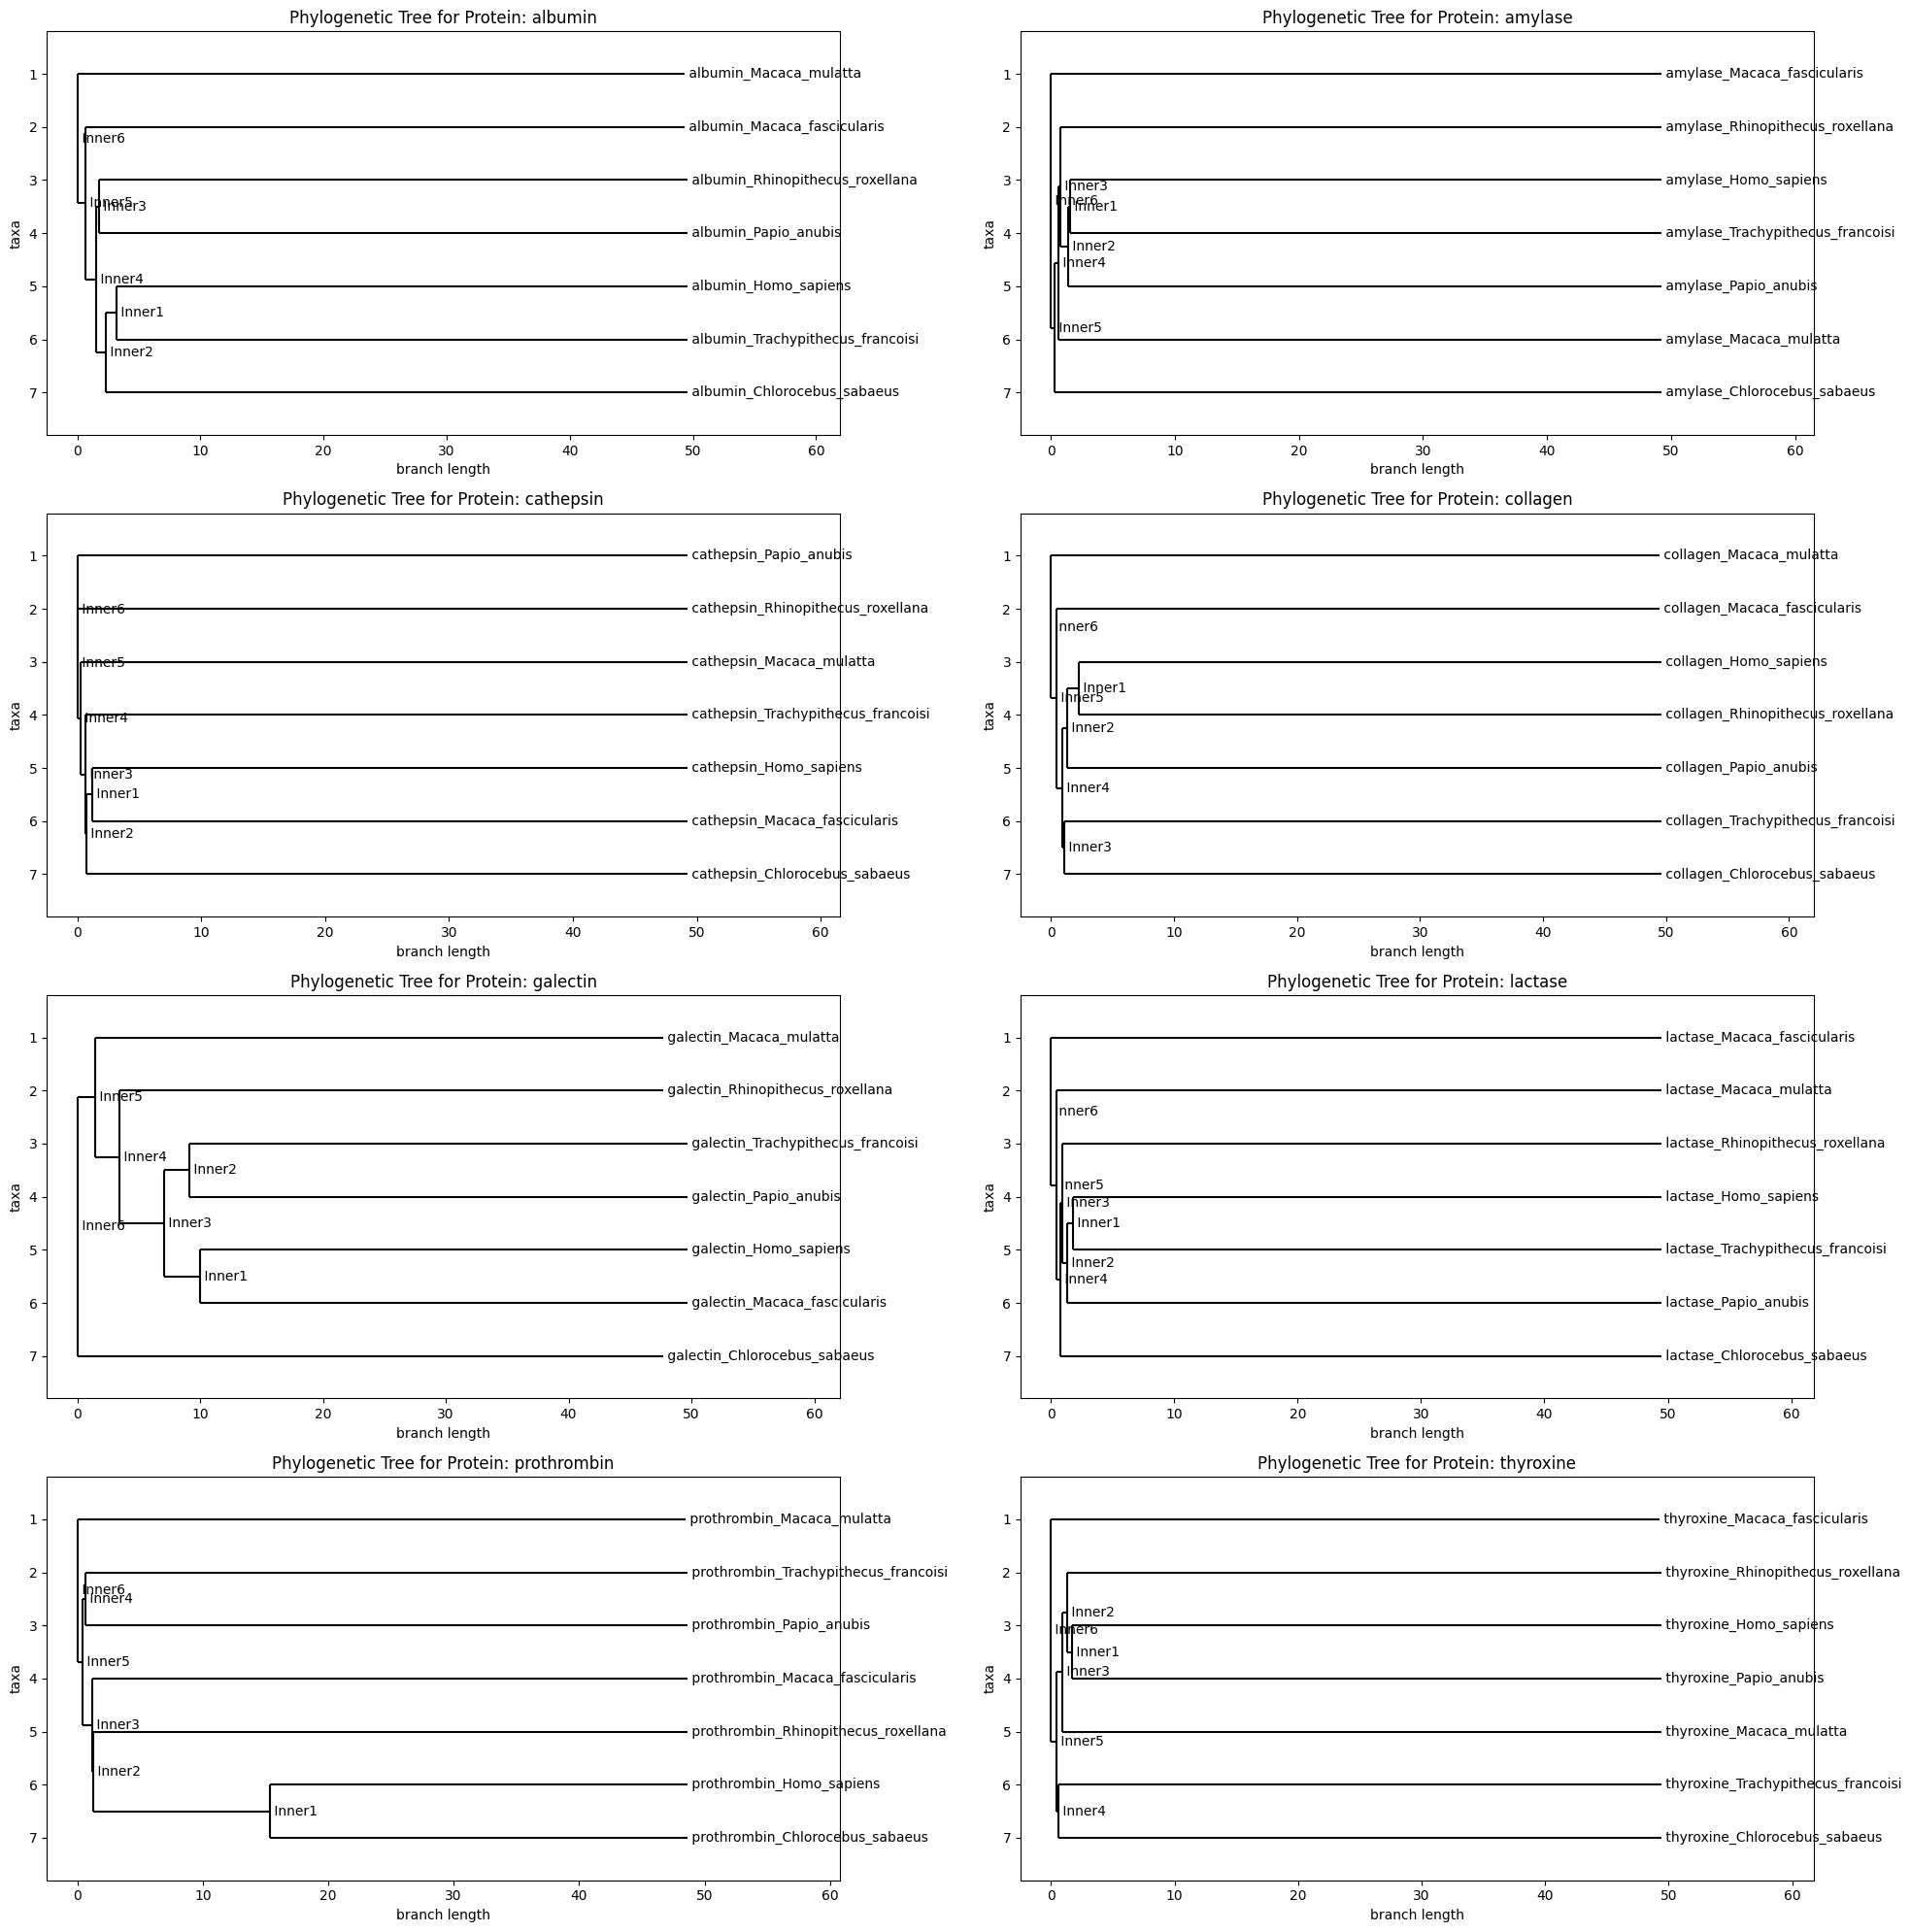

In [15]:
fig = plt.figure(figsize=(20, num_rows * 5))
gs = GridSpec(num_rows, num_columns, figure=fig)

group_trees = {}
for idx, group in enumerate(protein_groups):
    group_sequences = blast_df[blast_df['Protein'] == group]['Query ID'].unique()
    group_matrix = similarity_matrix.loc[group_sequences, group_sequences]

    matrix, labels = convert_to_lower(group_matrix)

    bio_distance_matrix = DistanceMatrix(names=labels, matrix=matrix)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(bio_distance_matrix)
    group_trees[group] = tree

    ax = fig.add_subplot(gs[idx // num_columns, idx % num_columns])
    Phylo.draw(tree, axes=ax, do_show=False)
    ax.set_title(f"Phylogenetic Tree for Protein: {group}")

plt.tight_layout()

### Separate tree for each cluster

In [16]:
num_clusters = len(cluster_df['Cluster'].unique())
num_columns = 2
num_rows = ceil(num_clusters / num_columns)

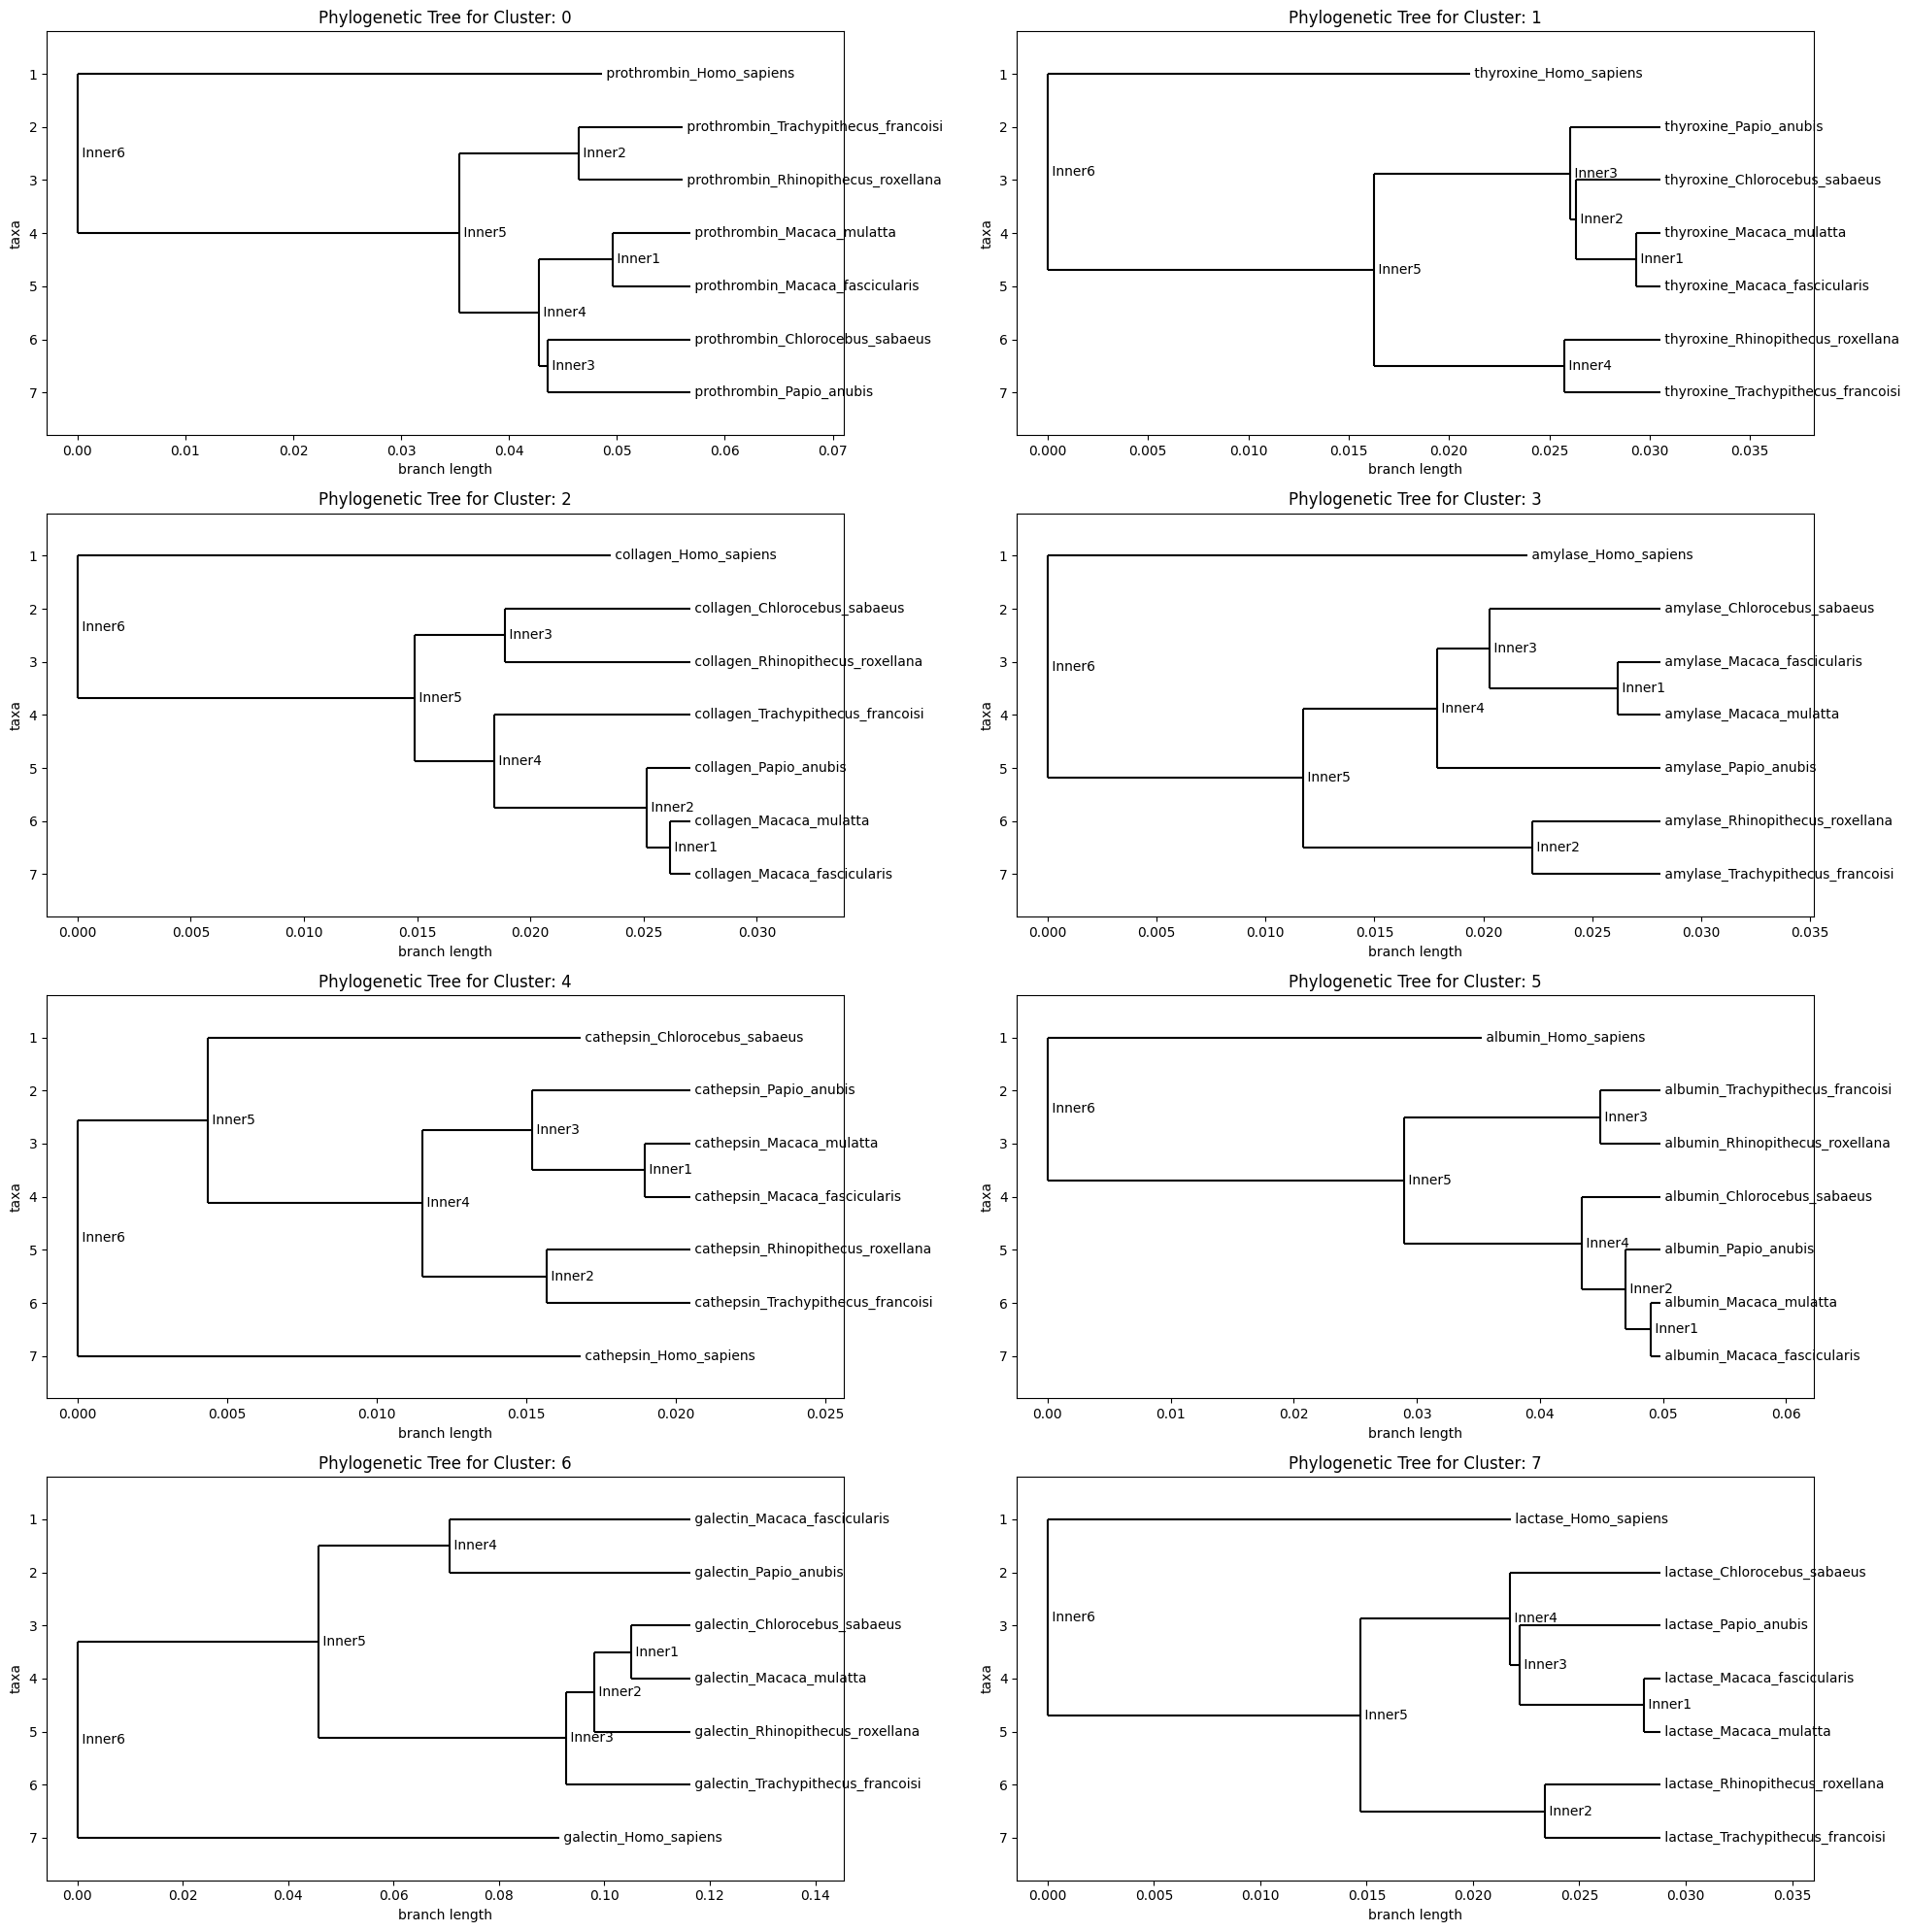

In [17]:
fig = plt.figure(figsize=(20, num_rows * 5))
gs = GridSpec(num_rows, num_columns, figure=fig)  

cluster_trees = {}
for idx, cluster in enumerate(cluster_df['Cluster'].unique()):
    cluster_elements = cluster_df[cluster_df['Cluster'] == cluster]['Sequence']
    cluster_matrix = distance_matrix.loc[cluster_elements, cluster_elements]

    matrix, labels = convert_to_lower(cluster_matrix)

    bio_distance_matrix = DistanceMatrix(names=labels, matrix=matrix)
    constructor = DistanceTreeConstructor()
    tree = constructor.upgma(bio_distance_matrix)
    cluster_trees[cluster] = tree 

    ax = fig.add_subplot(gs[idx // num_columns, idx % num_columns])

    Phylo.draw(tree, axes=ax, do_show=False)
    ax.set_title(f"Phylogenetic Tree for Cluster: {cluster}")

plt.tight_layout()

### One common tree for all downloaded sequences

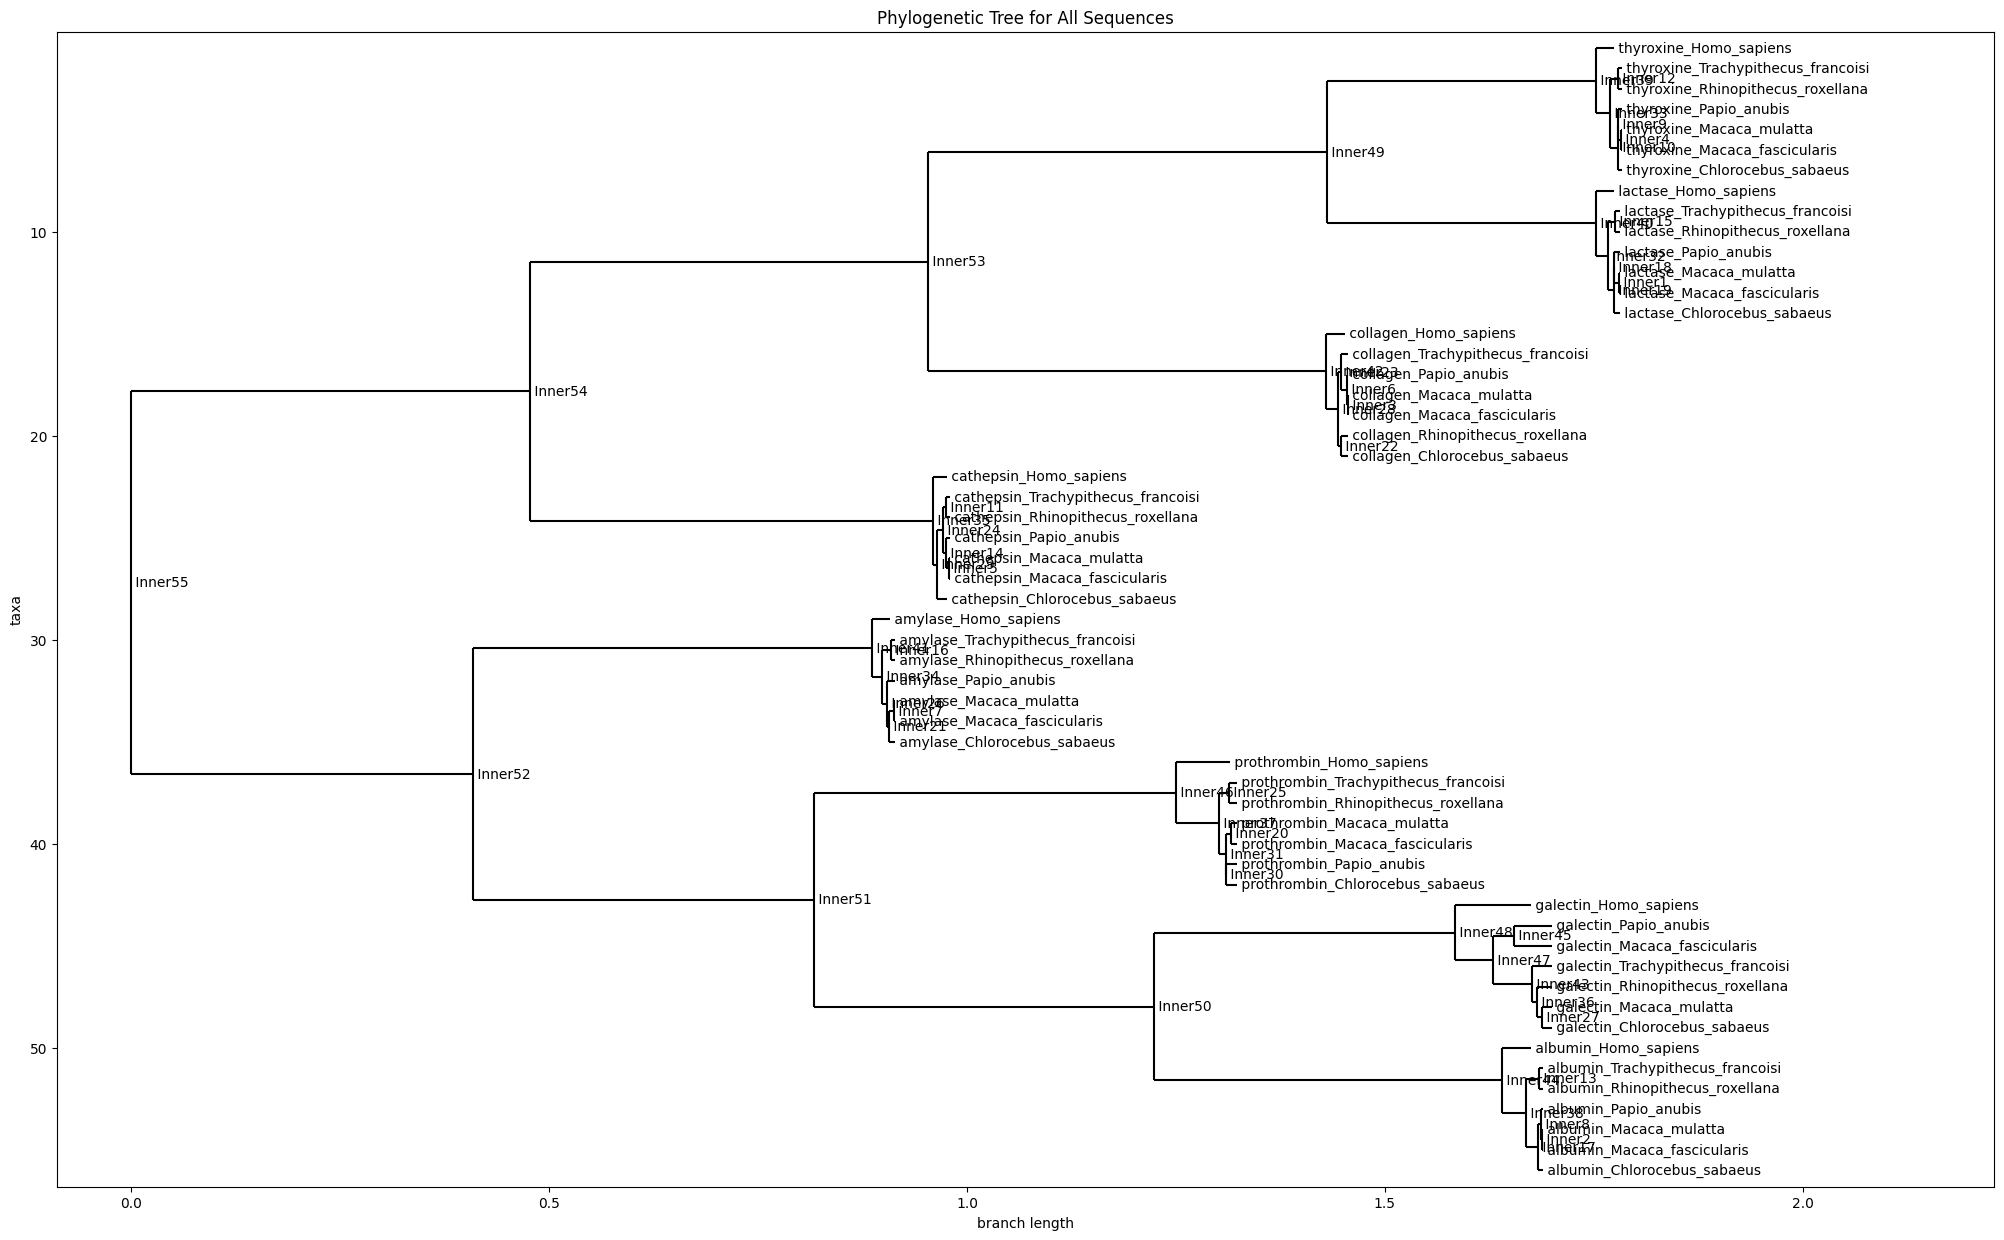

In [77]:
matrix_all, labels_all = convert_to_lower(distance_matrix)
bio_distance_matrix = DistanceMatrix(names=labels_all, matrix=matrix_all)

constructor = DistanceTreeConstructor()
combined_tree = constructor.upgma(bio_distance_matrix)

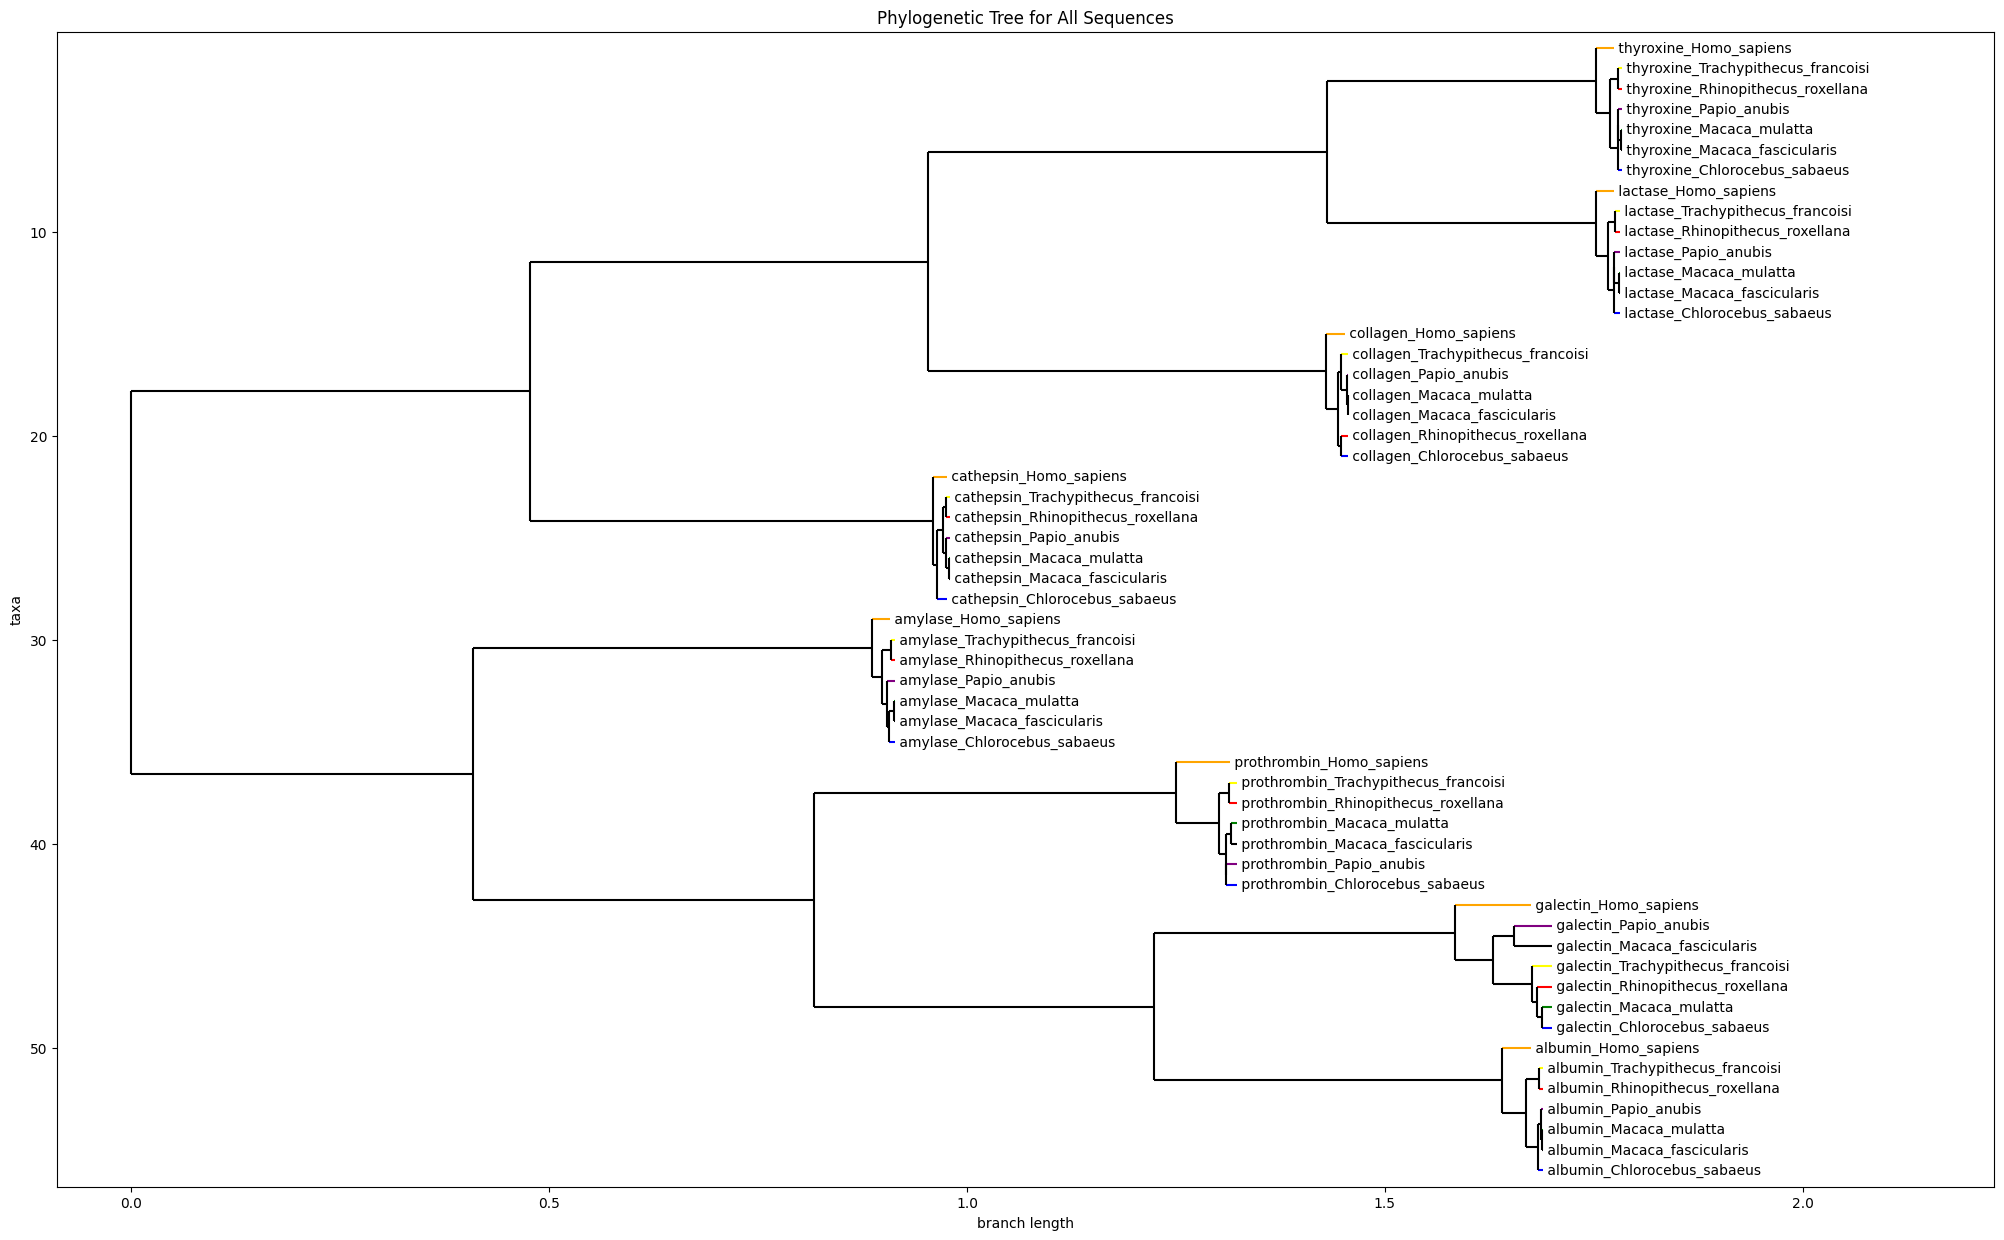

In [146]:
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(combined_tree, axes=ax, do_show=False, label_func=lambda x: x.name if x.is_terminal() else None)
ax.set_title("Phylogenetic Tree for All Sequences")
plt.show()

## Consensus trees

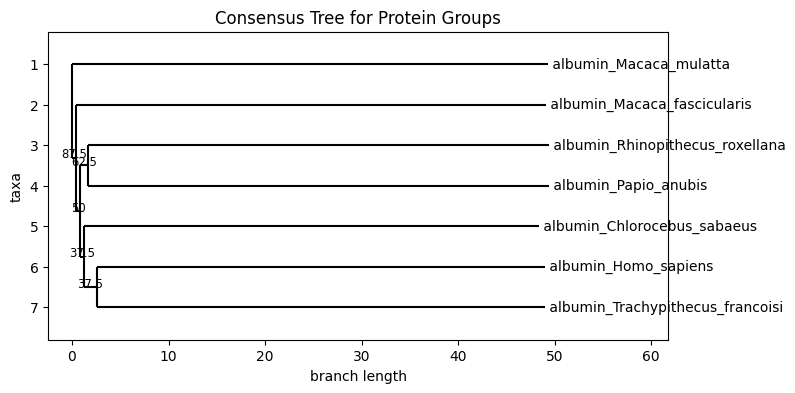

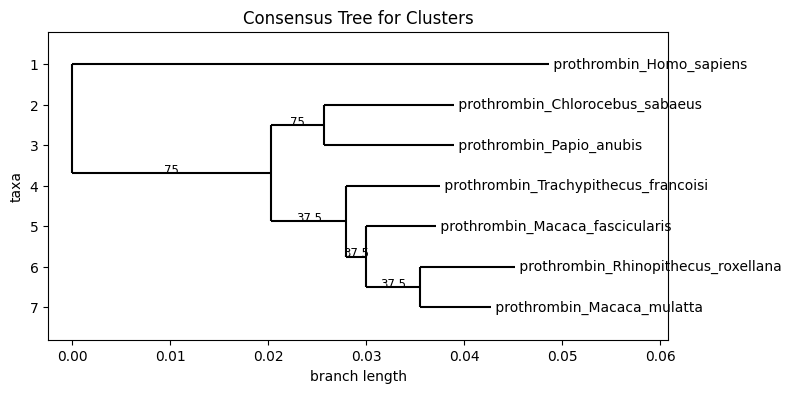

In [100]:
from Bio.Phylo.Consensus import majority_consensus
from Bio import Phylo
import matplotlib.pyplot as plt

# Example consensus tree creation from protein group and cluster trees
consensus_group_tree = majority_consensus(list(group_trees.values()))
consensus_cluster_tree = majority_consensus(list(cluster_trees.values()))

# Plot consensus tree for protein groups
plt.figure(figsize=(8, 4))
ax1 = plt.gca()
Phylo.draw(consensus_group_tree, axes=ax1, do_show=False)
ax1.set_title("Consensus Tree for Protein Groups")
plt.show()

# Plot consensus tree for clusters
plt.figure(figsize=(8, 4))
ax2 = plt.gca()
Phylo.draw(consensus_cluster_tree, axes=ax2, do_show=False)
ax2.set_title("Consensus Tree for Clusters")
plt.show()


## Coloring the tree

In [275]:
organism_colors = {
    'Macaca mulatta': 'green',
    'Rhinopithecus roxellana': 'red',
    'Chlorocebus sabaeus': '#00BFFF',
    'Homo sapiens': 'orange',
    'Trachypithecus francoisi': 'navy',
    'Papio anubis': '#FF1493'
}

protein_colors = {
    'cathepsin': 'green',
    'prothrombin': 'red',
    'thyroxine': 'orange',
    'galectin': 'purple',
    'lactase': 'navy',
    'albumin': 'teal',
    'collagen': '#00BFFF',
    'amylase': '#FF1493'
}

In [276]:
def label_extractor(name):
    parts = name.split('_', 1)  
    organism = parts[0].replace('_', ' ') 
    protein = parts[1].replace('_', ' ') if len(parts) > 1 else None  
    return organism, protein

In [277]:
def color_tree(tree, color_mapping, label_extractor, org=True):
    label_colors = {}
    for clade in tree.find_clades():
        if clade.name:
            protein, organism = label_extractor(clade.name)
            label = organism if org else protein
            if label in color_mapping:
                clade.color = color_mapping[label]  
                label_colors[clade.name] = color_mapping[label]  
            else:
                clade.color = 'black' 
    return label_colors

### Consensus tree

### Common tree - organisms

In [278]:
label_colors = color_tree(combined_tree, organism_colors, label_extractor)

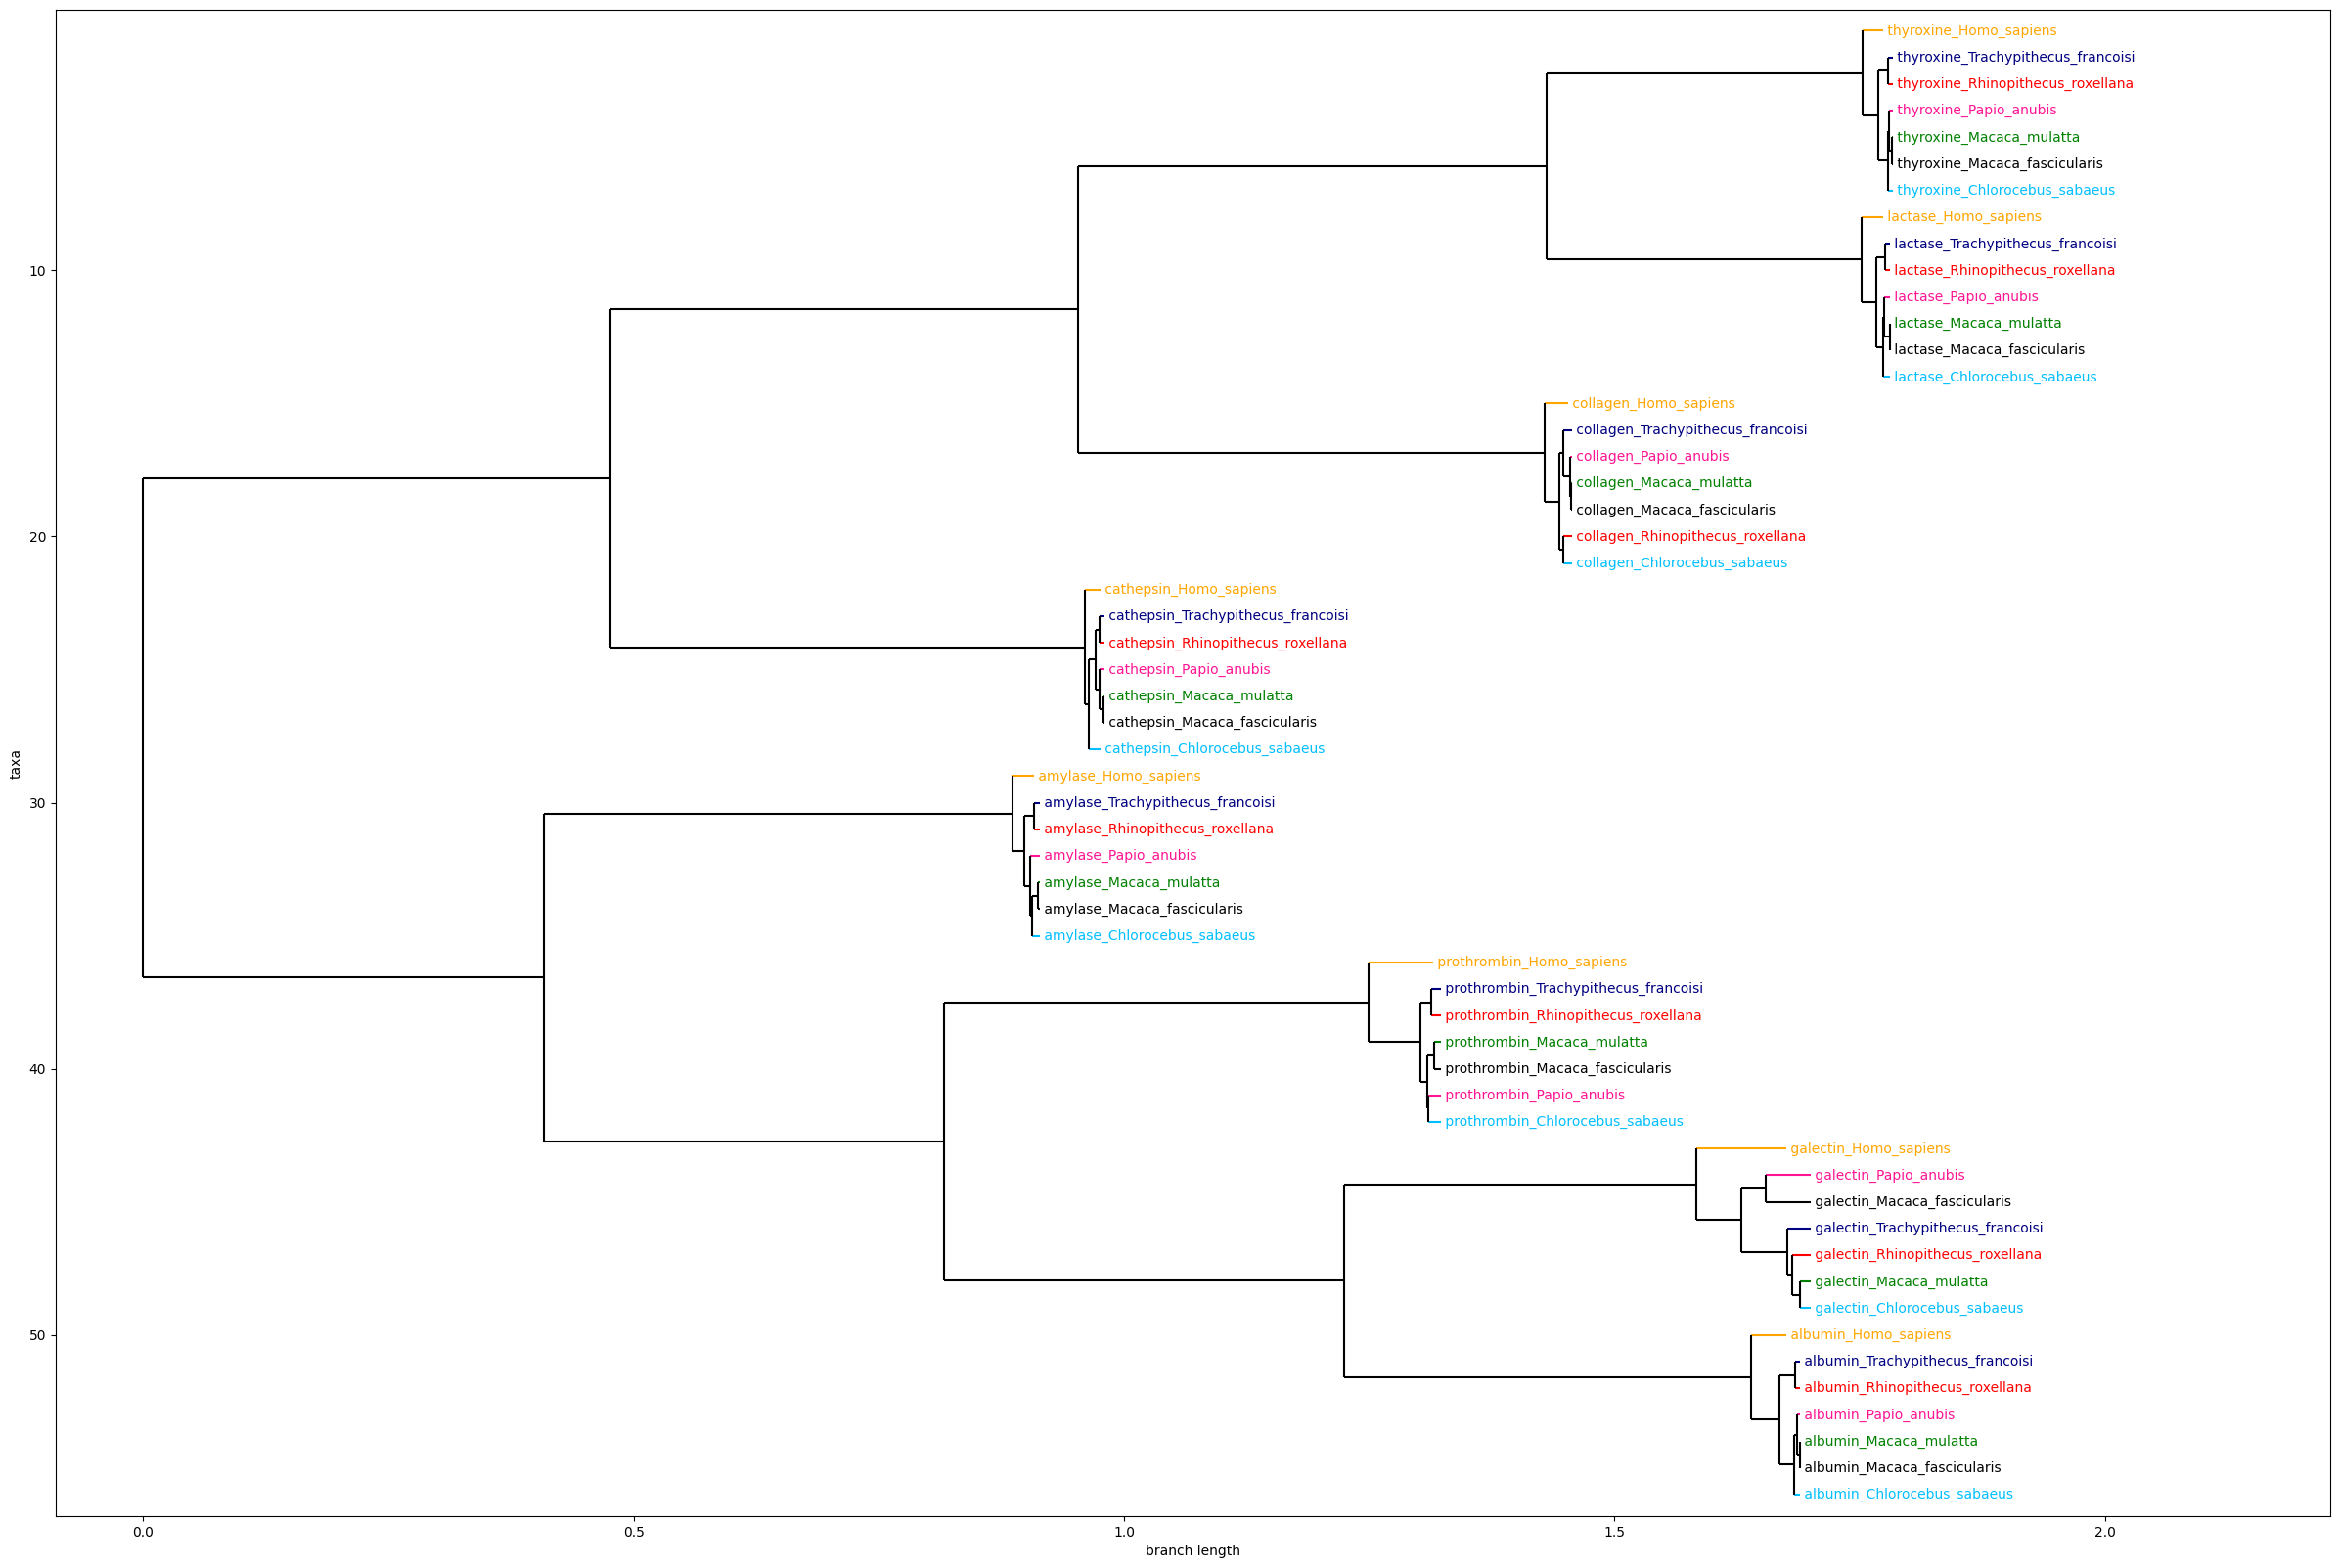

In [279]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(combined_tree, axes=ax, label_func=lambda x: x.name if x.is_terminal() else None, label_colors=label_colors)

### Common tree - organisms

In [280]:
label_colors = color_tree(combined_tree, protein_colors, label_extractor, org=False)

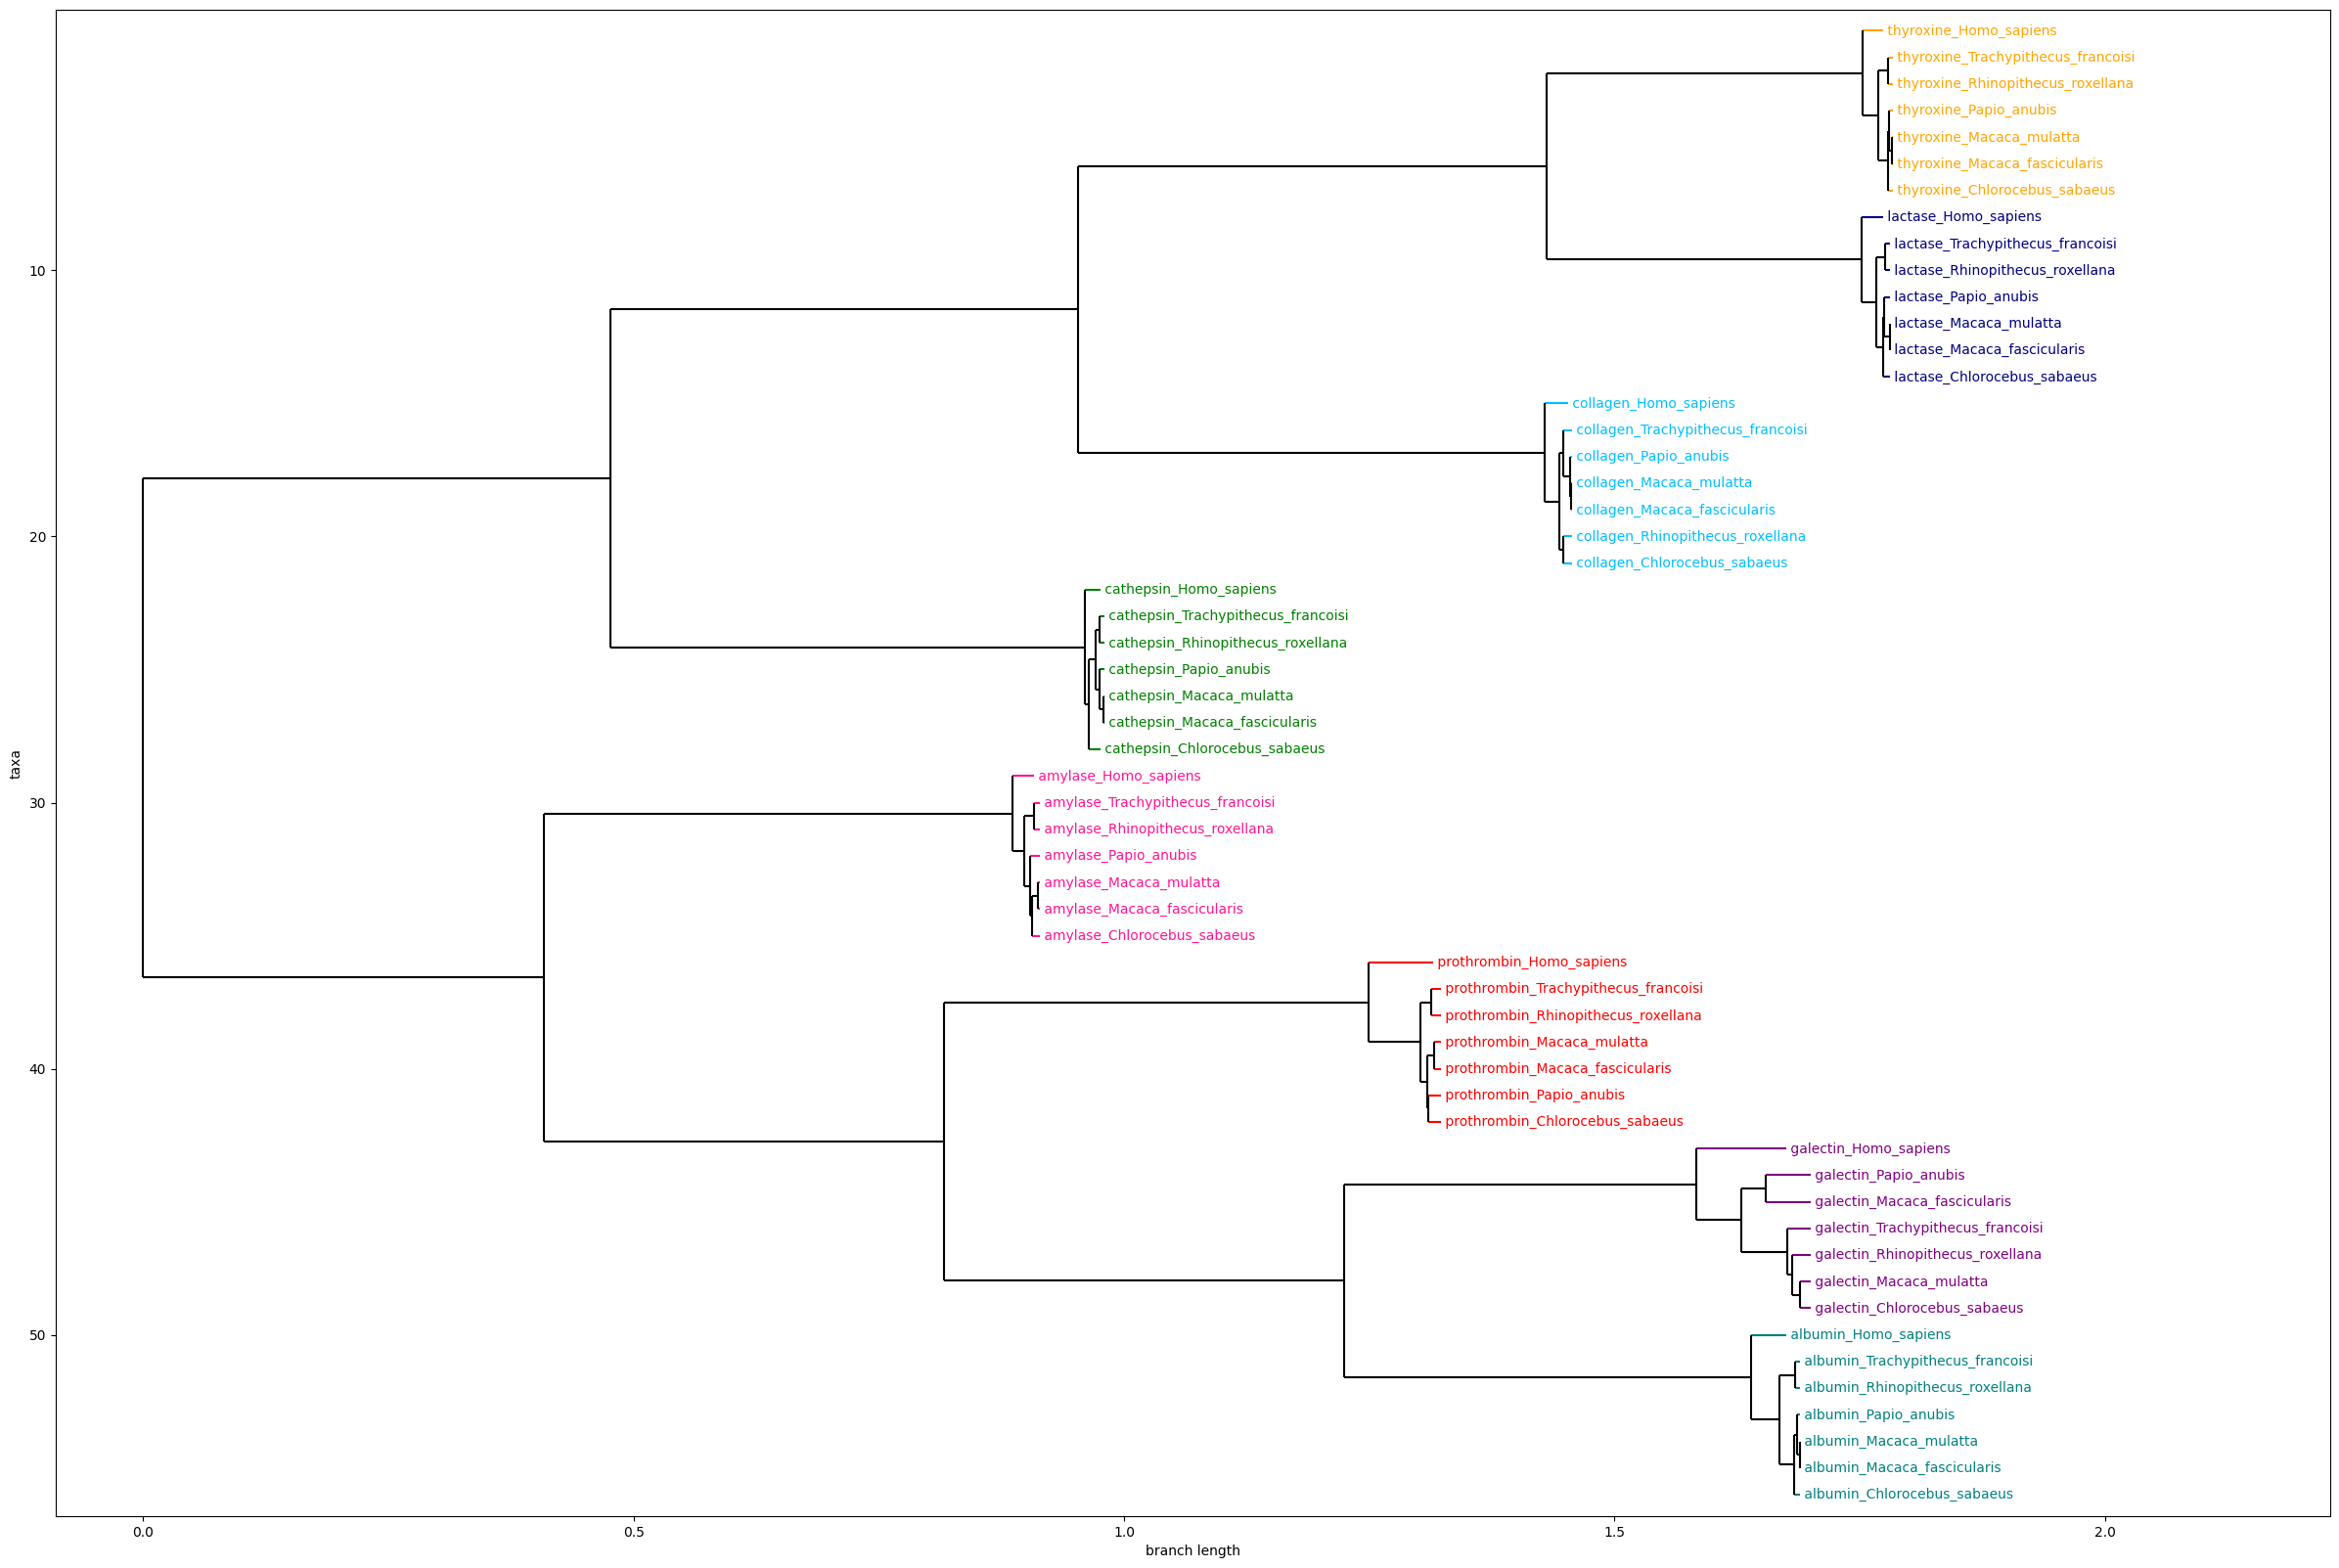

In [281]:
fig = plt.figure(figsize=(30, 20))
ax = fig.add_subplot(1, 1, 1)
Phylo.draw(combined_tree, axes=ax, label_func=lambda x: x.name if x.is_terminal() else None, label_colors=label_colors)